https://www.kaggle.com/competitions/vehicle/overview

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
# Import library
import os
import shutil
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil

In [3]:
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [4]:
import itertools
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
path_train_orig='vehicle/train/trainset/'

In [7]:
pd.DataFrame(os.listdir(path_train_orig)).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Ambulance,Barge,Bicycle,Boat,Bus,Car,Cart,Caterpillar,Helicopter,Limousine,Motorcycle,Segway,Snowmobile,Tank,Taxi,Truck,Van


In [8]:
# make dataset
data=[]
for categories in os.listdir(path_train_orig):
    #for f in glob.iglob(path+'data/*.SAFE')
    for img in os.listdir(path_train_orig+categories):
        data.append((path_train_orig+categories+'/'+img, categories, img))
                    
df_train=pd.DataFrame(data, columns=['data_path', 'class', 'imagen' ])
df_train

,data_path,class,imagen
0,vehicle/train/trainset/Ambulance/000040_09.jpg,Ambulance,000040_09.jpg
1,vehicle/train/trainset/Ambulance/000050_10.jpg,Ambulance,000050_10.jpg
2,vehicle/train/trainset/Ambulance/000052_03.jpg,Ambulance,000052_03.jpg
3,vehicle/train/trainset/Ambulance/000057_04.jpg,Ambulance,000057_04.jpg
4,vehicle/train/trainset/Ambulance/000067_14.jpg,Ambulance,000067_14.jpg
...,...,...,...
28040,vehicle/train/trainset/Van/005431_18.jpg,Van,005431_18.jpg
28041,vehicle/train/trainset/Van/005435_02.jpg,Van,005435_02.jpg
28042,vehicle/train/trainset/Van/005449_00.jpg,Van,005449_00.jpg
28043,vehicle/train/trainset/Van/005481_05.jpg,Van,005481_05.jpg


In [9]:
# value count of class
df_train['class'].value_counts()

Boat           8695
Car            6781
Motorcycle     2986
Bus            2133
Truck          2033
Bicycle        1618
Van            1111
Taxi            748
Helicopter      668
Caterpillar     331
Tank            206
Barge           202
Segway          153
Ambulance       132
Snowmobile      123
Limousine        74
Cart             51
Name: class, dtype: int64

In [10]:
categories = df_train['class'].unique()

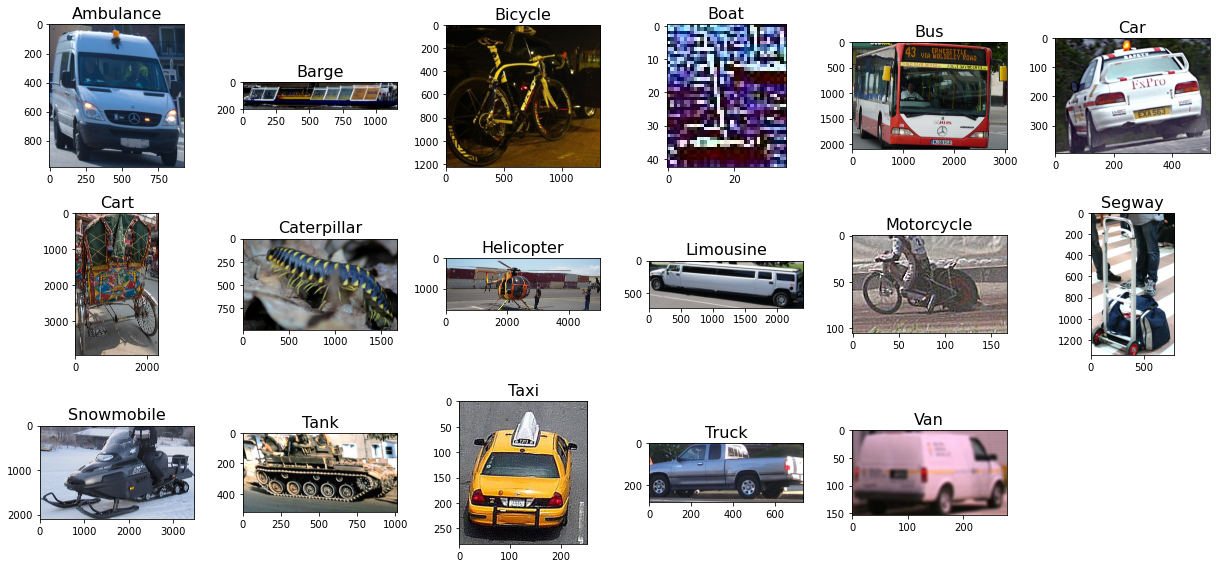

In [11]:
# check examples of image 
images=[]
for category in categories:
    cl = df_train[df_train['class'] == category]
    images.append(cl.sample(n=1)['data_path'].values[0])

plt.figure(figsize = (17, 8));
i=1
for im in images: 
    ax=plt.subplot(ceil(len(images)/6),6,i)
    img = cv2.imread(im)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(im.split('/')[-2],fontsize=16)
    plt.tight_layout();
    i+=1

In [12]:
categories = df_train['class'].unique()

In [13]:
X=df_train.drop('class', axis=1)

In [14]:
# label encoder (class)
y=LabelEncoder().fit_transform(df_train['class'].values)
y

array([ 0,  0,  0, ..., 16, 16, 16])

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [16]:
X_train.shape, y_train.shape

((22436, 2), (22436,))

In [17]:
X_val.shape, y_val.shape

((5609, 2), (5609,))

In [18]:
def make_dataframe_src_dst(df, path_orig, folder1, folder2):
     
    # make dataframe src-dst 
    sym=df[['data_path']].applymap(lambda x: x.replace(folder1, folder2))
    sym.columns=['dst']
    sym['src']=df['data_path'].copy()
    sym=sym[['src','dst']]
    #print(sym.head(2))
    # make directory of links for data flow from directory
    path = os.path.join('', *path_orig.split('/')[:-2],folder2)
    for new_path in categories:
        if os.path.exists(path+'/'+ new_path):
            shutil.rmtree(path+'/'+ new_path)
            os.makedirs(path+'/'+ new_path)
        else:
            os.makedirs(path+'/'+ new_path)

    # make symlink
    for index, row in sym.iterrows():
        os.symlink(os.getcwd()+'/'+row['src'], os.getcwd()+'/'+row['dst'])

In [19]:
# make dataset train - val
make_dataframe_src_dst(X_train, path_train_orig, 'trainset', 'train_folder')
make_dataframe_src_dst(X_val, path_train_orig, 'trainset', 'val_folder')

In [20]:
train_path=os.path.join('', *path_train_orig.split('/')[:-2],'train_folder/')
val_path=os.path.join('', *path_train_orig.split('/')[:-2],'val_folder/')
test_path='vehicle/test/testset/'

In [21]:
train_path, val_path, test_path

('vehicle/train/train_folder/',
 'vehicle/train/val_folder/',
 'vehicle/test/testset/')

In [22]:
# min-max image values
img.min(), img.max()

(2, 255)

## Convolutional Neural Network (CNN)

In [23]:
# epochs
epochs_val = 2

# batch_size
batch_size_val = 32

# target_size
#224
target_size_val=(75,75)

# input_shape
input_shape_val = (target_size_val[0],target_size_val[1], 3)

### Datagen

In [24]:
# Datagen and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    preprocessing_function=None)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

### Data Generator

In [25]:
# Train / Validation - Data Generator
train_generator = train_datagen.flow_from_directory(train_path,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(val_path,
                                 target_size=target_size_val,
                                 batch_size=batch_size_val,
                                 class_mode = 'categorical')

# Test 
test_generator = validation_datagen.flow_from_directory(test_path,
                                 target_size=target_size_val,
                                 shuffle = False,
                                 class_mode = 'categorical')

Found 22436 images belonging to 17 classes.
Found 5609 images belonging to 17 classes.
Found 0 images belonging to 0 classes.


In [26]:
# example from DataFrame
# Train Data Generator from DataFrame
train_generator_df = train_datagen.flow_from_dataframe(dataframe=df_train, # original, without validation split
                                              x_col='data_path', 
                                              y_col='class', 
                                              target_size=target_size_val,      
                                              batch_size=batch_size_val,
                                              class_mode = 'categorical')

Found 28045 validated image filenames belonging to 17 classes.


### plot images of train_generator

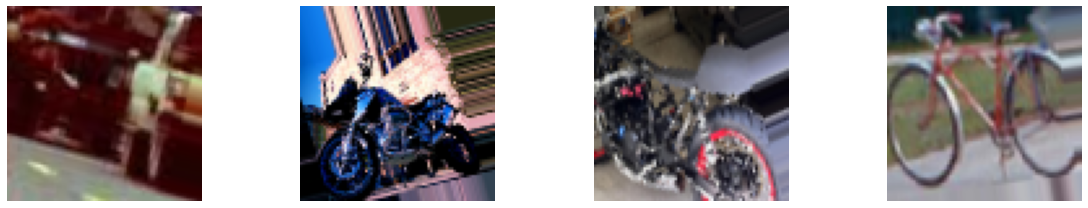

In [27]:
# plot image of train_generator
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(19,3))
for i in range(4):
  im = next(train_generator)[0][i]
  # (n, x, y, 3) to (x, y, 3)
  im = np.squeeze(im)
  # plot raw pixel data
  ax[i].imshow(im)
  ax[i].axis('off')
  plt.tight_layout()

### Models

In [28]:
# Custom model

model_custom = models.Sequential()
model_custom.add(Conv2D(32, (3, 3), strides = 1, padding = 'same', activation = 'relu', input_shape=input_shape_val))
model_custom.add(MaxPooling2D((2, 2), padding = 'same'))

model_custom.add(Conv2D(64, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(MaxPooling2D((2, 2), padding = 'same'))

model_custom.add(Conv2D(64, (3, 3), strides=1, padding = 'same', activation = 'relu'))
model_custom.add(MaxPooling2D((2, 2), padding = 'same'))

model_custom.add(Flatten())
model_custom.add(Dense(units = 64, activation = 'relu'))
model_custom.add(Dropout(0.2))
model_custom.add(Dense(units = 32, activation = 'relu'))
model_custom.add(Dropout(0.2))

model_custom.add(Dense(1, activation = 'sigmoid'))

# name
model_custom._name = "model_custom"
# summary
#model_custom.summary()

2022-04-26 00:06:57.427533: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-26 00:06:57.427579: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hellraiserPC
2022-04-26 00:06:57.427588: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hellraiserPC
2022-04-26 00:06:57.427768: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.60.2
2022-04-26 00:06:57.427800: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.60.2
2022-04-26 00:06:57.427808: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.60.2
2022-04-26 00:06:57.428149: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

In [29]:
# Model EfficientNet

model_EfficientNet = tf.keras.applications.EfficientNetB7(
    weights='imagenet', include_top = False, input_shape = input_shape_val)

for layer in model_EfficientNet.layers:
    layer.trainable=False
    
x = model_EfficientNet.output
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)

# output layer
output_EfficientNet = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model
model_EfficientNet = tf.keras.Model(inputs=model_EfficientNet.input, outputs=output_EfficientNet)

# name
model_EfficientNet._name = "model_EfficientNet"
# summary
#model_EfficientNet.summary()

### class_weight - optimizer - overfitting

In [30]:
# class_weight - Unbalanced Data
class_weights = dict(zip(np.unique(y_train), 
                         class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)))
class_weights

{0: 12.450610432852386,
 1: 8.146695715323167,
 2: 1.0199109009909992,
 3: 0.18973040625105705,
 4: 0.7731486267617768,
 5: 0.2432746001626457,
 6: 32.18938307030129,
 7: 4.980244173140955,
 8: 2.471469486671073,
 9: 22.36889332003988,
 10: 0.5524339497205328,
 11: 10.817743490838959,
 12: 13.466986794717887,
 13: 7.998573975044564,
 14: 2.2069643911076136,
 15: 0.8116634107517545,
 16: 1.4845497254019717}

In [31]:
# Define optimizer
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [32]:
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=4) 

### Compile and Fit models function

In [33]:
if os.path.exists('models/'):
    pass
else:
    os.makedirs('models/')

In [34]:
# run models fuction

filepath=os.getcwd()+'/models/'
def run_model(model):
    
    # save best model (callback)
    modelCheckpoint = ModelCheckpoint(filepath+'{}.h5'.format(model.name), save_best_only = True)
    
    # Compile the model
    model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
    
    # Fit the model
    history = model.fit_generator(generator=train_generator,
                              epochs = epochs_val,
                              steps_per_epoch=X_train.shape[0] // (batch_size_val*10),
                              callbacks=[early_stopping, lr, modelCheckpoint],
                              class_weight=class_weights,
                              validation_data = validation_generator)
    
    print(history.history.keys())
    
    return model, history

### Plot models function

In [35]:
def plot_model_output(history, name='model'):
    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['accuracy']
    val_accuracy_values = history_dict['val_accuracy']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Run and plot model

In [36]:
max_accuracy=[]

In [37]:
# Run model 
custom_model, history_custom = run_model(model_custom)
max_accuracy.append(('{}.h5'.format(custom_model.name),np.max(history_custom.history['accuracy'])))

Epoch 1/2
70/70 [==============================] - 240s 3s/step - loss: 0.2457 - accuracy: 0.9361 - val_loss: 0.2376 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 2/2
70/70 [==============================] - 123s 2s/step - loss: 0.2508 - accuracy: 0.9412 - val_loss: 0.2275 - val_accuracy: 0.9412 - lr: 0.0010
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [38]:
# Run model
EfficientNet_model, history_EfficientNet = run_model(model_EfficientNet)
max_accuracy.append(('{}.h5'.format(EfficientNet_model.name),np.max(history_EfficientNet.history['accuracy'])))

Epoch 1/2
70/70 [==============================] - 292s 4s/step - loss: 1.7946 - accuracy: 0.8604 - val_loss: 0.3365 - val_accuracy: 0.9412 - lr: 0.0010
Epoch 2/2
70/70 [==============================] - 284s 4s/step - loss: 0.3578 - accuracy: 0.9200 - val_loss: 0.2240 - val_accuracy: 0.9412 - lr: 0.0010
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


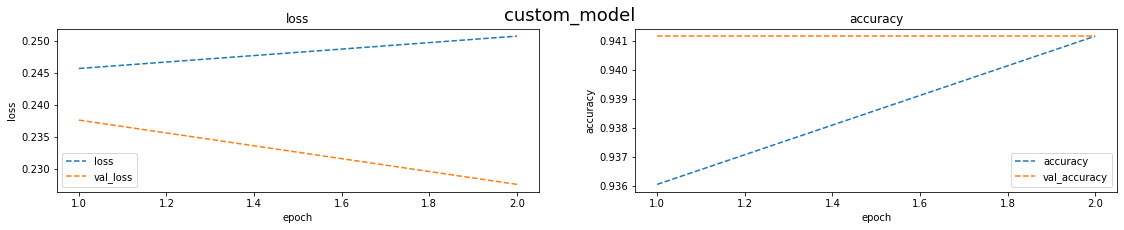

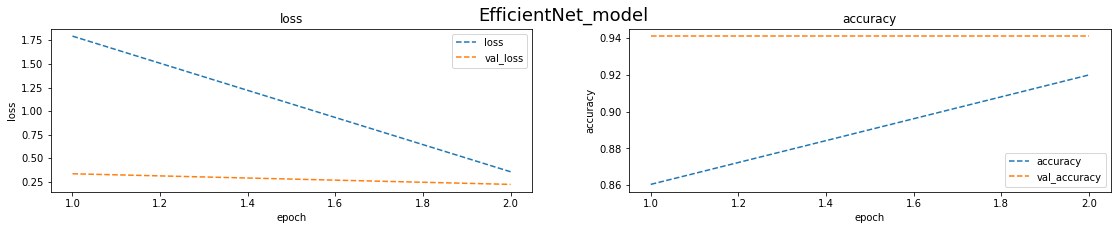

In [40]:
# plot model ouputs
plot_model_output(history_custom, 'custom_model')
plot_model_output(history_EfficientNet, 'EfficientNet_model')

In [41]:
# get best model
best_model_df=pd.DataFrame(max_accuracy, columns=['model','accuracy'])
best_model_df.sort_values(by=['accuracy'], ascending=False, inplace=True)
best_model_df

,model,accuracy
0,model_custom.h5,0.941177
1,model_EfficientNet.h5,0.920036


In [42]:
best_model=best_model_df.iloc[0]['model']

In [43]:
# load best model
load_model = tf.keras.models.load_model('models/'+best_model, compile = False)
load_model

In [44]:
#resnet_model.evaluate(test_generator)
#load_model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])
#load_model.evaluate(test_generator)

In [45]:
predictions = load_model.predict(test_generator)

ValueError: Asked to retrieve element 0, but the Sequence has length 0

In [46]:
predictions[0:3]

NameError: name 'predictions' is not defined

In [47]:
filenames = test_generator.filenames
nb_samples = len(filenames)
steps = np.ceil(nb_samples/batch_size_val)
predict = load_model.predict_generator(test_generator, steps)

ValueError: Asked to retrieve element 0, but the Sequence has length 0